# Project Title:
Predicting Legendary Pokémon Using In-Game Stats and Traits

## Project Link:
https://www.kaggle.com/datasets/shreyasdasari7/golden-pokdex-kanto-to-hoenn

## Challenge Overview:
In the Pokémon franchise, certain species are considered "Legendary" — rare, powerful creatures that are central to the lore and gameplay. But what makes a Pokémon legendary from a data-driven perspective? This project aims to use machine learning to predict whether a Pokémon is Legendary based on its game attributes such as base stats, typing, physical characteristics, and capture-related features.

## Data Description:
The dataset includes information from the Kanto, Johto, and Hoenn regions, containing ~380 Pokémon entries and 24 attributes. Features include:

Base Stats: HP, Attack, Defense, etc.

Types (Type 1, Type 2)

Physical traits: Height, Weight, Shape, Color

Capture info: Catch Method, Capture Rate

Evolution Stage and Hidden Ability
The target variable is Is Legendary (True or False).

## Type of Machine Learning:
This is a Supervised Classification problem — specifically a binary classification task (Legendary vs Non-Legendary).

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [20]:
#load sets
kanto_df = pd.read_csv("Kanto.csv")
johto_df = pd.read_csv("Johto.csv")
hoenn_df = pd.read_csv("Hoenn.csv")

#combine datasets
pokemon_df = pd.concat([kanto_df, johto_df, hoenn_df], ignore_index=True)

In [21]:
print("Shape:", pokemon_df.shape)
print("Missing Values:", pokemon_df.isnull().sum())
print("Target Distribution (Is Legendary):", pokemon_df["Is Legendary"].value_counts())

Shape: (386, 25)
Missing Values: ID                      135
Name                      0
Generation                0
Region                    0
Type 1                    0
Type 2                  204
Base HP                   0
Base Attack               0
Base Defense              0
Base Special Attack       0
Base Special Defense      0
Base Speed                0
Total Base Stats          0
Height (m)                0
Weight (kg)               0
Capture Rate              0
Is Legendary              0
Evolution Stage           0
Hidden Ability            8
Gender Ratio              0
Catch Method              1
Base Friendship           1
Color                     1
Shape                     1
Number                  251
dtype: int64
Target Distribution (Is Legendary): Is Legendary
False    365
True      21
Name: count, dtype: int64


The missing values are expected bc not all pokemon have a type 2 and number isnt really needed for the model.

In [22]:
summary = []

for col in pokemon_df.columns:
    if pokemon_df[col].dtype == "object":
        feature_type = "Categorical"
        unique_vals = pokemon_df[col].dropna().unique()
        values = ", ".join(map(str, unique_vals[:5])) + ("..." if len(unique_vals) > 5 else "")
    else:
        feature_type = "Numerical"
        values = f"{pokemon_df[col].min()} to {pokemon_df[col].max()}"

    missing = pokemon_df[col].isnull().sum()
    
    summary.append({
        "Feature": col,
        "Type": feature_type,
        "Values / Range": values,
        "Missing Values": missing
    })

summary_df = pd.DataFrame(summary)
print("Feature Summary:", summary_df)

Feature Summary:                  Feature         Type  \
0                     ID    Numerical   
1                   Name  Categorical   
2             Generation    Numerical   
3                 Region  Categorical   
4                 Type 1  Categorical   
5                 Type 2  Categorical   
6                Base HP    Numerical   
7            Base Attack    Numerical   
8           Base Defense    Numerical   
9    Base Special Attack    Numerical   
10  Base Special Defense    Numerical   
11            Base Speed    Numerical   
12      Total Base Stats    Numerical   
13            Height (m)    Numerical   
14           Weight (kg)    Numerical   
15          Capture Rate    Numerical   
16          Is Legendary    Numerical   
17       Evolution Stage    Numerical   
18        Hidden Ability  Categorical   
19          Gender Ratio  Categorical   
20          Catch Method  Categorical   
21       Base Friendship    Numerical   
22                 Color  Categorical   

In [23]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

In [24]:
# testing to see outliers
outliers = detect_outliers(pokemon_df, "Total Base Stats")
print("Outliers in 'Total Base Stats':")
print(outliers[["Name", "Total Base Stats", "Is Legendary"]])

Outliers in 'Total Base Stats':
Empty DataFrame
Columns: [Name, Total Base Stats, Is Legendary]
Index: []


There can be outliers bc we're testing for legendary pokemon and they are considered the target here.

In [25]:
pokemon_df["Is Legendary"].value_counts()
#this is used to clearly see the target variable

Is Legendary
False    365
True      21
Name: count, dtype: int64

In [26]:
#defining numeric features
numeric_features = [
    "Base HP", "Base Attack", "Base Defense", "Base Special Attack",
    "Base Special Defense", "Base Speed", "Total Base Stats",
    "Height (m)", "Weight (kg)", "Capture Rate", "Base Friendship"
]

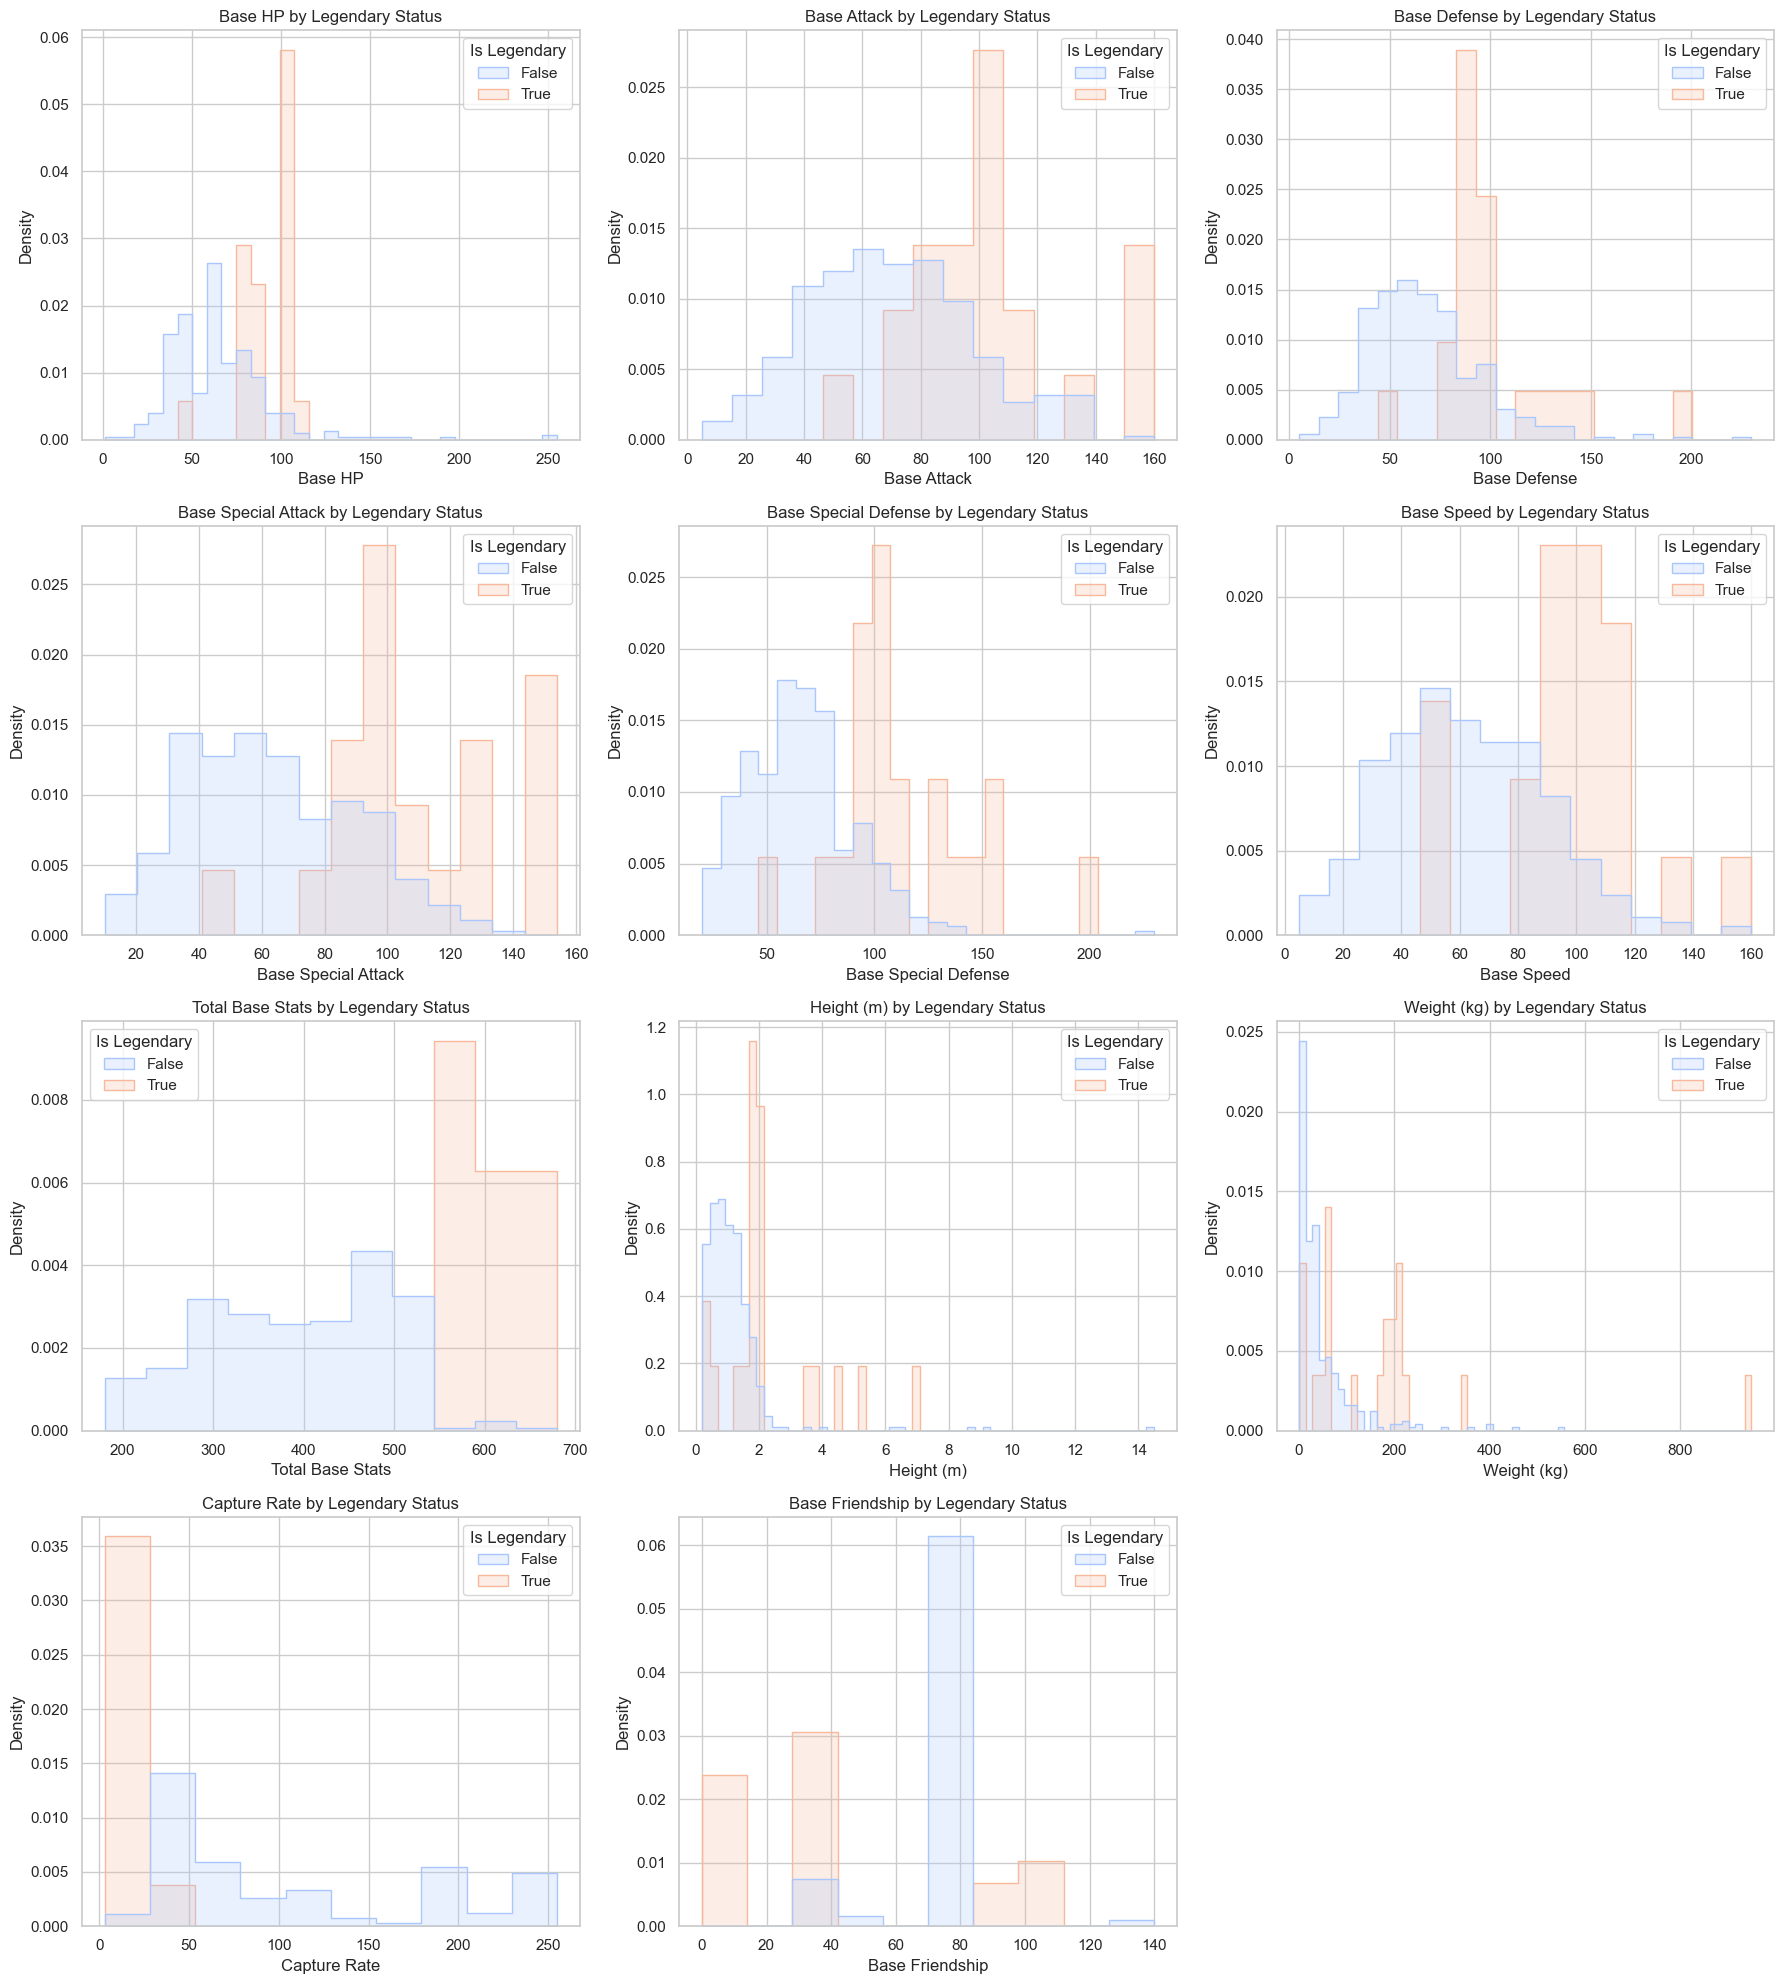

In [27]:
#producing a histogram by class
sns.set(style="whitegrid")
n_cols = 3
n_rows = (len(numeric_features) + n_cols - 1) // n_cols

plt.figure(figsize=(18, 5 * n_rows))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        data=pokemon_df,
        x=feature,
        hue="Is Legendary",
        kde=False,
        stat="density",
        element="step",
        common_norm=False,
        palette="coolwarm"
    )
    plt.title(f"{feature} by Legendary Status")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

In [28]:
#define categorical features
categorical_features = [
    "Type 1", "Type 2", "Generation", "Region",
    "Color", "Shape", "Catch Method"
]

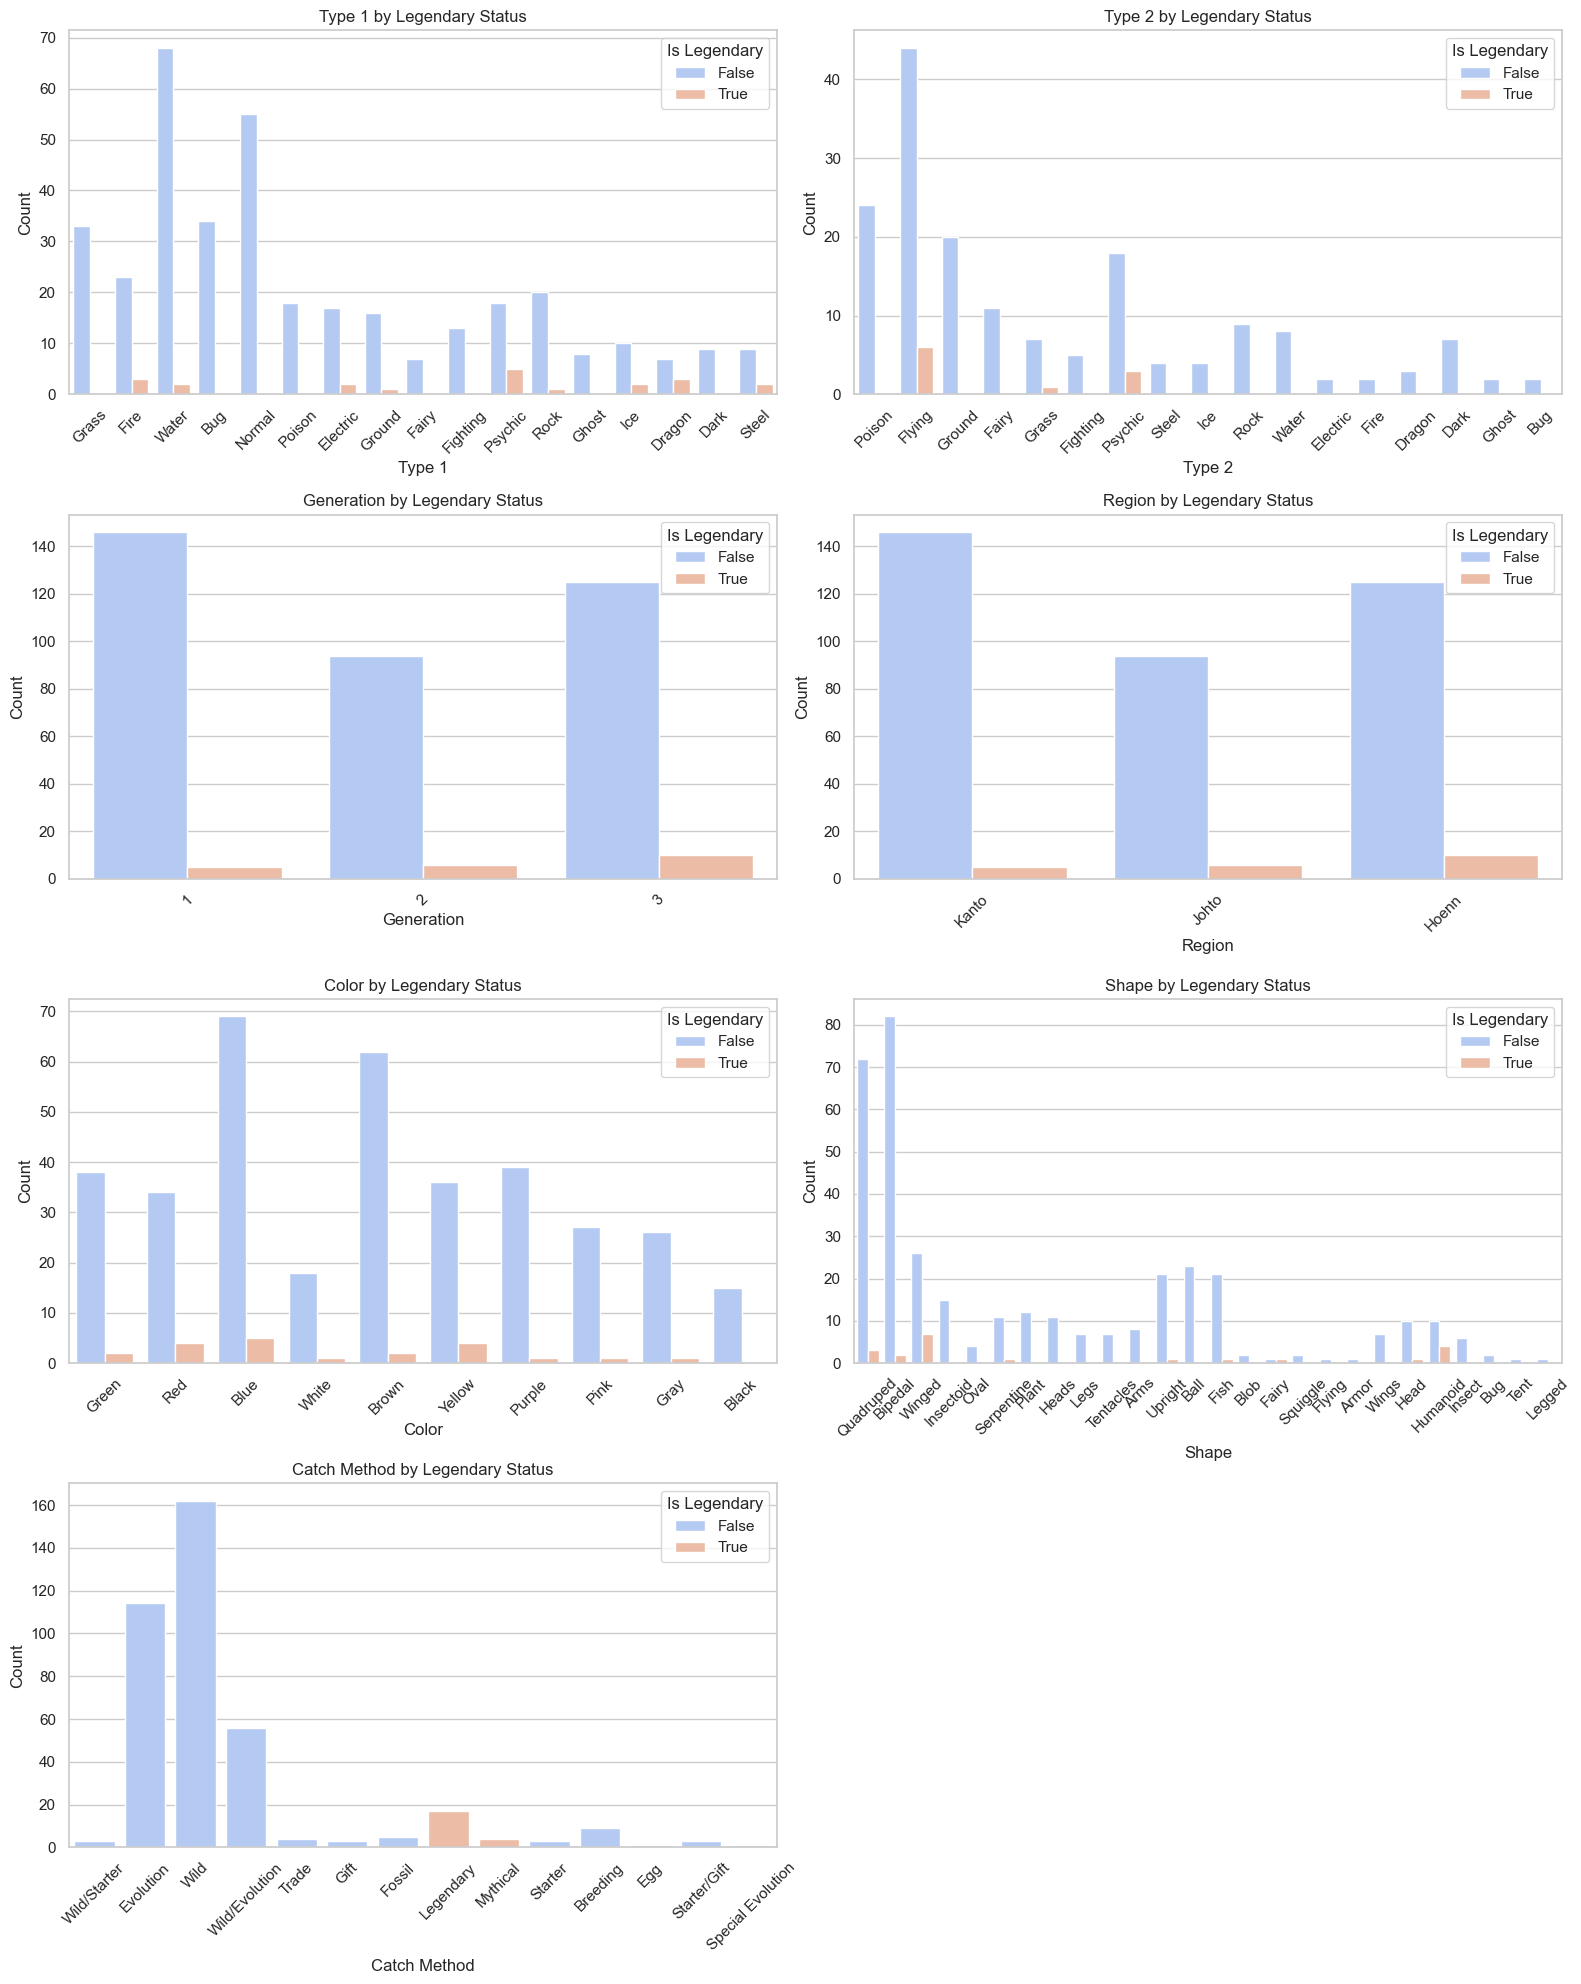

In [29]:
n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

plt.figure(figsize=(16, 5 * n_rows))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        data=pokemon_df,
        x=feature,
        hue="Is Legendary",
        palette="coolwarm"
    )
    plt.title(f"{feature} by Legendary Status")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [30]:
#categorical features in a table
type_summary = pokemon_df.groupby("Type 1")["Is Legendary"].agg(
    Total="count",
    Legendary_Count="sum"
)
type_summary["% Legendary"] = 100 * type_summary["Legendary_Count"] / type_summary["Total"]
print(type_summary.sort_values("% Legendary", ascending=False))

          Total  Legendary_Count  % Legendary
Type 1                                       
Dragon       10                3    30.000000
Psychic      23                5    21.739130
Steel        11                2    18.181818
Ice          12                2    16.666667
Fire         26                3    11.538462
Electric     19                2    10.526316
Ground       17                1     5.882353
Rock         21                1     4.761905
Water        70                2     2.857143
Normal       55                0     0.000000
Poison       18                0     0.000000
Bug          34                0     0.000000
Dark          9                0     0.000000
Ghost         8                0     0.000000
Fighting     13                0     0.000000
Fairy         7                0     0.000000
Grass        33                0     0.000000


In [31]:
clean_df = pokemon_df.drop(columns=["ID", "Number", "Name"])

In [32]:
#fill missing Type 2 with 'None'
clean_df["Type 2"] = clean_df["Type 2"].fillna("None")

#drop rows with small missing amounts in key features
clean_df = clean_df.dropna(subset=[
    "Hidden Ability", "Catch Method", "Base Friendship", "Color", "Shape"
])

In [33]:
#redefining the features to be scaled
numeric_features = [
    "Base HP", "Base Attack", "Base Defense", "Base Special Attack",
    "Base Special Defense", "Base Speed", "Total Base Stats",
    "Height (m)", "Weight (kg)", "Capture Rate", "Base Friendship"
]

scaler = MinMaxScaler()
clean_df[numeric_features] = scaler.fit_transform(clean_df[numeric_features])

categorical_features = [
    "Type 1", "Type 2", "Generation", "Region", "Color", "Shape", "Catch Method"
]
clean_df = pd.get_dummies(clean_df, columns=categorical_features)

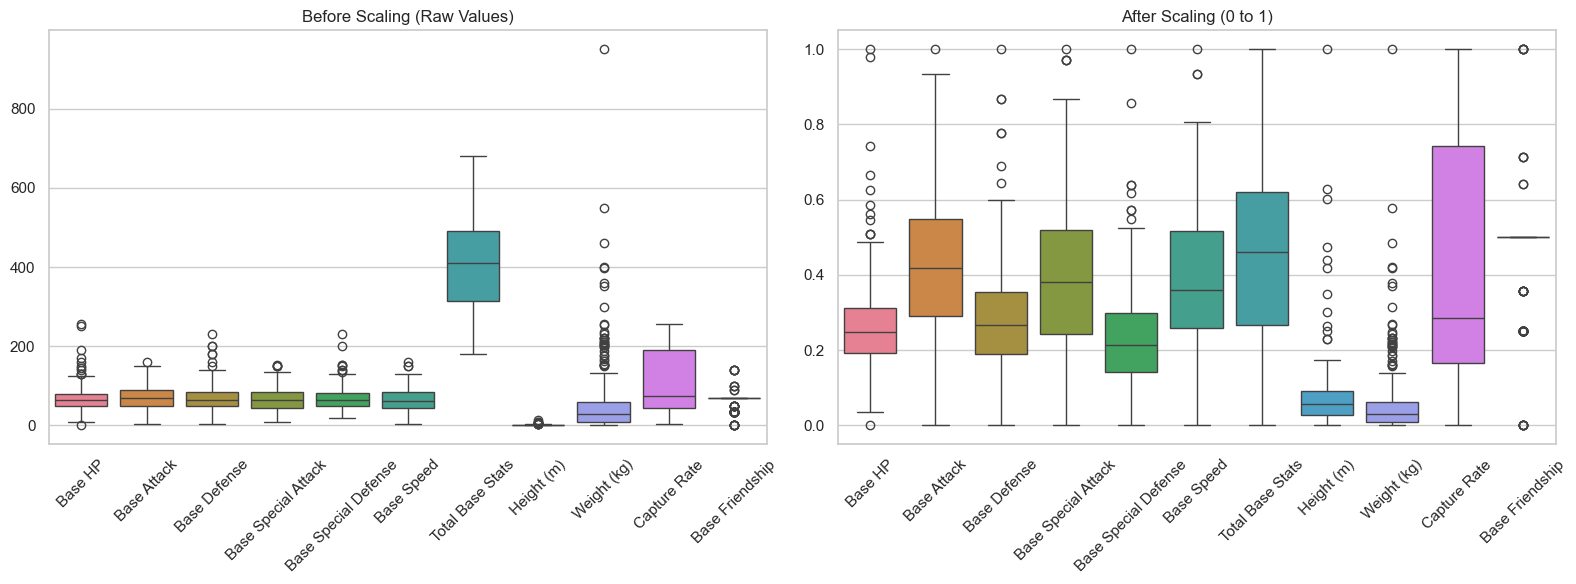

Cleaned DataFrame shape: (377, 106)
    Base HP  Base Attack  Base Defense  Base Special Attack  \
0  0.173228     0.283871      0.195556             0.381944   
1  0.232283     0.367742      0.257778             0.486111   
2  0.311024     0.496774      0.346667             0.625000   
3  0.149606     0.303226      0.168889             0.347222   
4  0.224409     0.380645      0.235556             0.486111   

   Base Special Defense  Base Speed  Total Base Stats  Height (m)  \
0              0.214286    0.258065             0.276    0.034965   
1              0.285714    0.354839             0.450    0.055944   
2              0.380952    0.483871             0.690    0.125874   
3              0.142857    0.387097             0.258    0.027972   
4              0.214286    0.483871             0.450    0.062937   

   Weight (kg)  Capture Rate  ...  Catch Method_Gift  Catch Method_Legendary  \
0     0.007159      0.166667  ...              False                   False   
1     0.01

In [34]:
#save unscaled values for comparison
original_values = pokemon_df[numeric_features].dropna()

plt.figure(figsize=(16, 6))

#before scaling
plt.subplot(1, 2, 1)
sns.boxplot(data=original_values)
plt.xticks(rotation=45)
plt.title("Before Scaling (Raw Values)")

#after scaling
plt.subplot(1, 2, 2)
sns.boxplot(data=clean_df[numeric_features])
plt.xticks(rotation=45)
plt.title("After Scaling (0 to 1)")

plt.tight_layout()
plt.show()

print("Cleaned DataFrame shape:", clean_df.shape)
print(clean_df.head())

In [35]:
print("Dataset Shape:")
print("Rows:", clean_df.shape[0])
print("Columns:", clean_df.shape[1])

#check for missing values
missing_values = clean_df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Only show features with missing values

print("Missing Values (should be none):")
if missing_values.empty:
    print("No missing values")
else:
    print(missing_values)

print("Target Distribution (Is Legendary):")
print(clean_df["Is Legendary"].value_counts())

Dataset Shape:
Rows: 377
Columns: 106
Missing Values (should be none):
No missing values
Target Distribution (Is Legendary):
Is Legendary
False    356
True      21
Name: count, dtype: int64
